In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [3]:
df_sign = pd.read_csv(params.sign_csv, index_col=0, parse_dates=True) 

# Collect each day’s feature-engineered frame
frames = []
print('generating main features...')
for day, day_df in df_sign.groupby(df_sign.index.normalize()):
    # day_df has only that session’s bars
    feats_main = feats.features_creation(df = day_df, 
                                         ma_window = 20) # sma window for ATR and Volume
    frames.append(feats_main)

# Re-assemble back into one long DF
df_feat_main = pd.concat(frames).sort_index()

print('generating engineered features...')
df_feat_eng = feats.features_engineering(
                                        df = df_feat_main,
                                        low_rsi = 30,
                                        high_rsi = 70,
                                        adx_thresh = 20,
                                        adx_window = 7
                                        )

df_feat_eng

generating main features...
generating engineered features...


,ema,sma,macd_line,macd_signal,macd_diff,bb_lband,bb_hband,bb_width_20,rsi,plus_di,minus_di,adx,atr_14,atr_sma,atr_ratio,atr_ratio_sma,obv,obv_sma,vwap_dev,r_1,r_5,r_15,vol_15,volume_spike,stoch_k_14,stoch_d_3,hour,day_of_week,month,open,high,low,close,volume,bid,ask,signal,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div
2004-01-02 13:07:00,0.764283,0.764285,-0.000001,-2.670940e-07,-0.000001,0.764277,0.764292,0.000020,0.000000,0.000000,100.000000,100.000000,0.000001,5.978954e-08,0.000002,7.823102e-08,-34693.75,-1.734688e+03,-0.000022,-0.000022,-0.000022,-0.000022,0.000005,1.224427,0.000000,0.000000,13,4,1,0.764269,0.764269,0.764269,0.764269,34693.75,0.763698,0.764840,0.258111,-0.000,-0.000,0.000,30.000,-0.000,-3.295906e+04,0.0
2004-01-02 13:08:00,0.764278,0.764284,-0.000004,-9.540811e-07,-0.000003,0.764267,0.764300,0.000043,0.000000,0.000000,100.000000,100.000000,0.000002,1.750979e-07,0.000003,2.291084e-07,-76081.25,-5.538750e+03,-0.000043,-0.000022,-0.000044,-0.000044,0.000007,1.426955,0.000000,0.000000,13,4,1,0.764252,0.764252,0.764252,0.764252,41387.50,0.763681,0.764824,0.266279,-0.000,-0.000,0.000,30.000,-0.000,-7.054250e+04,0.0
2004-01-02 13:09:00,0.764272,0.764282,-0.000007,-2.133156e-06,-0.000005,0.764254,0.764308,0.000070,0.000000,0.000000,100.000000,100.000000,0.000003,3.419596e-07,0.000004,4.474464e-07,-124162.50,-1.174688e+04,-0.000065,-0.000022,-0.000066,-0.000066,0.000008,1.602274,0.000000,0.000000,13,4,1,0.764235,0.764235,0.764235,0.764235,48081.25,0.763664,0.764807,0.274718,-0.000,-0.000,0.000,30.000,-0.000,-1.124156e+05,0.0
2004-01-02 13:10:00,0.764264,0.764279,-0.000011,-3.821084e-06,-0.000007,0.764239,0.764316,0.000101,0.000000,0.000000,100.000000,100.000000,0.000004,5.566920e-07,0.000006,7.284294e-07,-178937.50,-2.069375e+04,-0.000086,-0.000022,-0.000088,-0.000088,0.000009,1.747383,0.000000,0.000000,13,4,1,0.764219,0.764219,0.764219,0.764219,54775.00,0.763647,0.764790,0.283435,-0.000,-0.000,0.000,30.000,-0.000,-1.582438e+05,0.0
2004-01-02 13:11:00,0.764254,0.764276,-0.000015,-5.997853e-06,-0.000009,0.764222,0.764324,0.000133,0.000000,0.000000,100.000000,100.000000,0.000005,8.158760e-07,0.000007,1.067586e-06,-240406.25,-3.271406e+04,-0.000107,-0.000022,-0.000110,-0.000110,0.000010,1.861544,0.000000,0.000000,13,4,1,0.764202,0.764202,0.764202,0.764202,61468.75,0.763631,0.764773,0.292439,-0.000,-0.000,0.000,30.000,-0.000,-2.076922e+05,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.464247,196.252523,0.175662,1.345260e-01,0.041136,195.916213,196.735377,0.004172,67.216594,36.312473,7.485222,30.194416,0.250991,1.852786e-01,0.001275,9.435851e-04,3773131.00,2.672338e+06,0.002191,0.000635,0.002846,0.003639,0.000724,1.952858,62.051653,56.011167,20,2,6,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.546641,0.212,0.041,-0.080,-37.217,10.194,1.100793e+06,3.3
2025-06-18 20:57:00,196.496671,196.279250,0.179462,1.435133e-01,0.035949,195.913925,196.783165,0.004427,61.668579,34.720671,6.704415,32.868467,0.260206,1.893612e-01,0.001323,9.642380e-04,3312501.00,2.714861e+06,0.001453,-0.000712,0.001450,0.003081,0.000746,2.143635,64.412431,61.090338,20,2,6,196.810000,196.940000,196.560000,196.675000,460630.00,196.527500,196.822500,0.529260,0.217,0.036,0.108,-31.669,12.868,5.976403e+05,3.6
2025-06-18 20:58:00,196.523337,196.306558,0.179996,1.508098e-01,0.029186,195.913821,196.824269,0.004636,61.473426,33.627161,6.493263,35.351515,0.249477,1.930490e-01,0.001269,9.828957e-04,2787256.00,2.725067e+06,0.001403,-0.000025,0.000559,0.002291,0.000747,2.234218,62.942847,63.135644,20,2,6,196.675000,196.740000,196.630000,196.670000,525245.00,196.522500,196.817500,0.506342,0.217,0.029,0.154,-31.473,15.352,6.218915e+04,2.9
2025-06-18 20:59:00,196.479747,196.318096,0.144060,1.494599e-01,-0.005400,195.910752,196.824338,0.004652,47.540108,29.057762,16.0

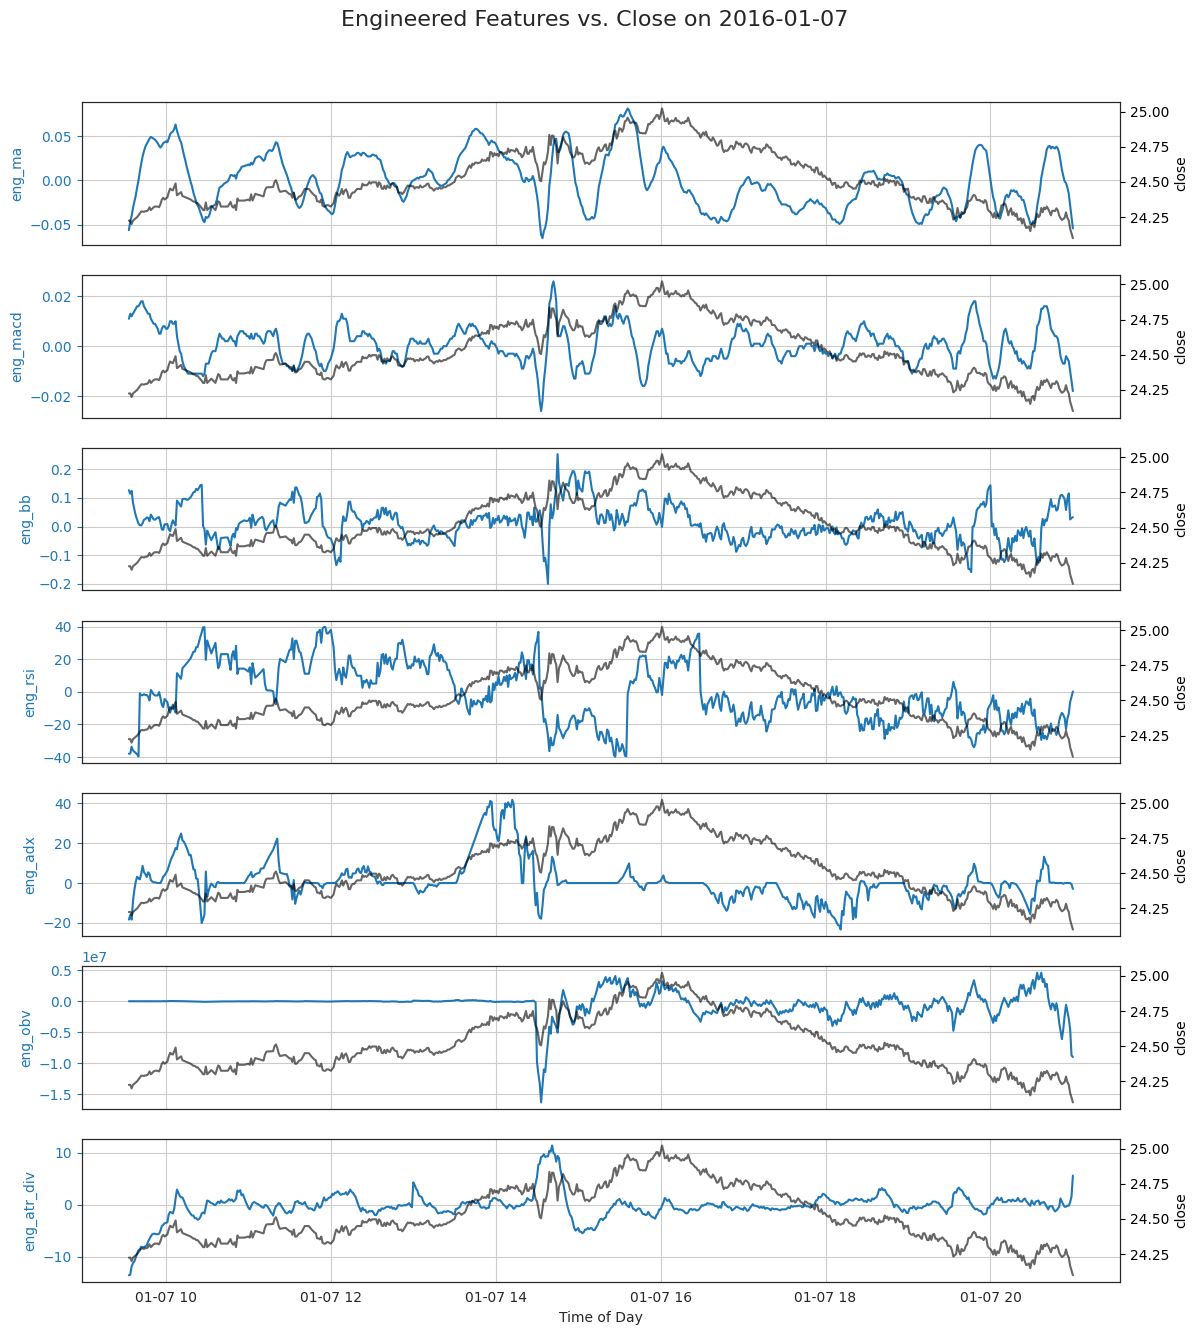

In [4]:
# 1) Identify engineered‐feature columns and the raw close price column
eng_features = [c for c in df_feat_eng.columns if c.startswith("eng_")]
close_col    = "close"

# 2) Pick a random trading day and convert to pandas Timestamp
all_days   = df_feat_eng.index.normalize().unique()
random_day = np.random.choice(all_days)
day_ts     = pd.to_datetime(random_day)

# 3) Subset the DataFrame to that single day
mask         = df_feat_eng.index.normalize() == random_day
df_day_feats = df_feat_eng.loc[mask, eng_features]
df_day_close = df_feat_eng.loc[mask, close_col]

# 4) Create one subplot per engineered feature
fig, axes = plt.subplots(
    nrows   = len(eng_features),
    ncols   = 1,
    figsize = (12, 2 * len(eng_features)),
    sharex  = True
)
fig.suptitle(f"Engineered Features vs. Close on {day_ts.date()}", fontsize=16)

# 5) Plot each feature on its own left‐y axis, and close price on a right‐y axis
for ax, feat in zip(axes, eng_features):
    # left axis: engineered feature
    ax.plot(df_day_feats.index, df_day_feats[feat],
            color="C0", label=feat)
    ax.set_ylabel(feat, color="C0")
    ax.tick_params(axis="y", colors="C0")
    ax.grid(True)

    # right axis: raw close price
    ax2 = ax.twinx()
    ax2.plot(df_day_close.index, df_day_close,
             color="k", alpha=0.6, label="close")
    ax2.set_ylabel("close", color="k")
    ax2.tick_params(axis="y", colors="k")

# 6) Final formatting
axes[-1].set_xlabel("Time of Day")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


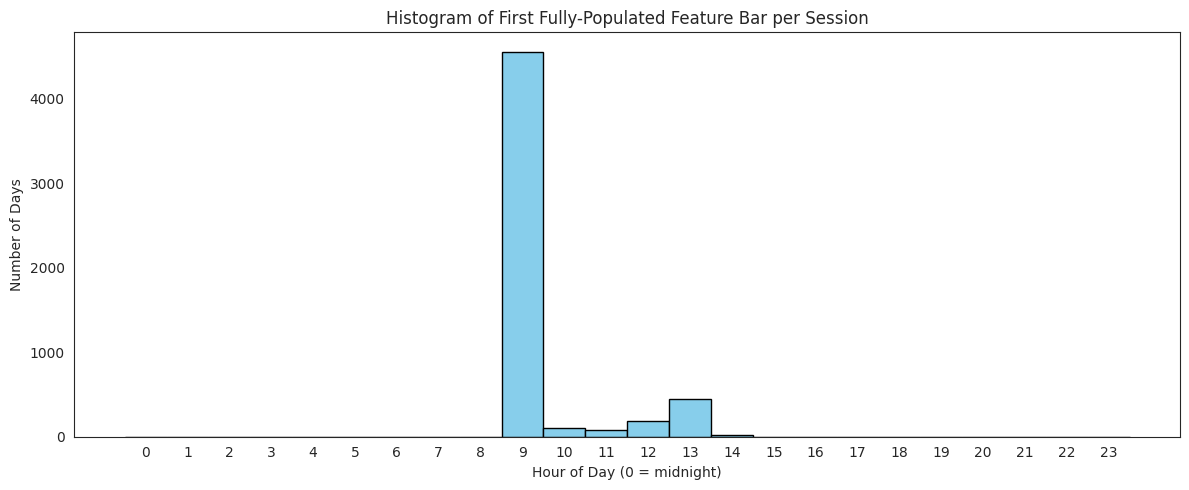

In [5]:
# -----------------------------------------------------------------------------
# What this plot shows:
#   We measure, for each trading day, the first 1-minute bar when *every* feature has a non-null value.  
#   Plotting the histogram of those hours tells how long the indicators take to “warm up” each morning before the model can run.
# -----------------------------------------------------------------------------

# 1) Prepare a DataFrame without bid/ask (and any non-feature cols)
df_feat_unsc = df_feat_eng.drop(columns=["bid", "ask"], errors="ignore")

# 2) Identify all feature columns (those starting with "feat_")
feat_cols = [c for c in df_feat_unsc.columns if c != 'signal']

# 3) For each calendar day, find the first timestamp where *all* feat_ cols are non-null
first_valid = (
    df_feat_unsc
      .groupby(df_feat_unsc.index.normalize())
      .apply(lambda grp: grp.dropna(subset=feat_cols).index.min())
)

# 4) Extract the hour (0–23) of that first fully-populated bar
first_valid_hours = first_valid.dt.hour

# 5) Plot the histogram
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),       # 24 one-hour bins
    align='left',
    color='skyblue',
    edgecolor='black'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Populated Feature Bar per Session')
plt.tight_layout()
plt.show()


In [6]:
# feed the trimmed DataFrame into the existing call
df_feat_all = feats.scale_with_splits(
    df           = df_feat_eng,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)

Scaling splits:   0%|          | 0/3 [00:00<?, ?split/s]

Applying PCA:   0%|          | 0/3 [00:00<?, ?split/s]

In [7]:
print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask
df_feat_all

saving df …


,bb_lband,bb_hband,atr_14,atr_sma,obv,obv_sma,open,high,low,close,volume,r_1,r_5,r_15,vol_15,bb_width_20,rsi,atr_ratio,atr_ratio_sma,vwap_dev,volume_spike,stoch_k_14,stoch_d_3,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:07:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.029117,-0.014129,-0.009476,-1.005076,-0.943230,-2.476841,-0.996380,-0.987015,-0.023336,0.107099,-1.552562,-1.585648,-0.001209,0.001484,0.031624,1.504436,-0.027995,-0.021099,-0.036212,0.507,-0.976,0.476,0.763698,0.764840,0.258111
2004-01-02 13:08:00,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029117,-0.027502,-0.017401,-1.001603,-0.937271,-2.476841,-0.994579,-0.986828,-0.027538,0.295962,-1.552562,-1.585648,-0.001209,0.001484,0.031624,1.504436,-0.027995,-0.029567,-0.036212,0.507,-0.976,0.476,0.763681,0.764824,0.266279
2004-01-02 13:09:00,-1.101323,1.046830,0.962963,1.182703,-1.074817,-1.240114,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029118,-0.040876,-0.025327,-0.999187,-0.930276,-2.476841,-0.992906,-0.986557,-0.031704,0.459452,-1.552562,-1.585648,-0.001209,0.001484,0.031624,1.504436,-0.027995,-0.039000,-0.036212,0.507,-0.976,0.476,0.763664,0.764807,0.274718
2004-01-02 13:10:00,-1.107230,1.033796,0.951510,1.195657,-1.092812,-1.282580,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029119,-0.054250,-0.033253,-0.997370,-0.922523,-2.476841,-0.991353,-0.986209,-0.035825,0.594770,-1.552562,-1.585648,-0.001209,0.001484,0.031624,1.504436,-0.027995,-0.049325,-0.036212,0.507,-0.976,0.476,0.763647,0.764790,0.283435
2004-01-02 13:11:00,-1.130188,1.017421,0.928571,1.241939,-1.130157,-1.383516,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-0.029119,-0.067624,-0.041178,-0.995973,-0.914218,-2.476841,-0.989911,-0.985789,-0.039897,0.701227,-1.552562,-1.585648,-0.001209,0.001484,0.031624,1.504436,-0.027995,-0.060465,0.005394,0.507,-0.976,0.476,0.763631,0.764773,0.292439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,-0.277336,0.170151,1.495611,0.794202,0.810448,0.355966,0.514056,0.712871,0.507812,0.711270,5.457497,0.833605,1.736669,1.315228,0.348747,0.119570,0.811095,0.582507,0.182057,0.406220,0.786381,0.354296,0.172658,12.115664,10.607205,-2.292321,-1.807845,0.348383,0.234328,1.336808,-0.941,0.039,0.015,196.667400,196.962600,0.546641
2025-06-18 20:57:00,-0.279616,0.237958,1.596673,0.836394,0.615883,0.371696,0.714286,0.834646,0.390625,0.485397,6.617038,-0.934444,0.884588,1.113128,0.391507,0.184714,0.539711,0.641713,0.207647,0.262926,0.964285,0.426843,0.332103,12.401440,9.313824,3.168949,-1.534453,0.447111,0.120971,1.461629,-0.941,0.039,0.015,196.527500,196.822500,0.529260
2025-06-18 20:58:00,-0.279472,0.297362,1.473427,0.877509,0.391635,0.375126,0.498008,0.520710,0.501626,0.476825,7.618132,-0.033735,0.340813,0.827243,0.392142,0.238300,0.530165,0.574130,0.230765,0.253285,1.048756,0.381683,0.396310,12.401440,7.503091,4.505218,-1.524795,0.538824,0.000337,1.170382,-0.941,0.039,0.015,196.522500,196.817500,0.506342
2025-06-18 20:59:00,-0.283468,0.298289,1.673496,0.931785,-0.465725,0.333652,0.504000,0.537549,-0.110089,-0.205079,31.539808,-2.873560,-0.840175,-0.093724,0.692251,0.242399,-0.151391,0.695123,0.261866,-0.172664,4.753099,-0.182061,0.213673,9.257911,-1.291897,16.996422,-0.838213,0.236622,-0.445174,1.461629,-0.941,0.039,0.015,196.092800,196.387200,0.490520


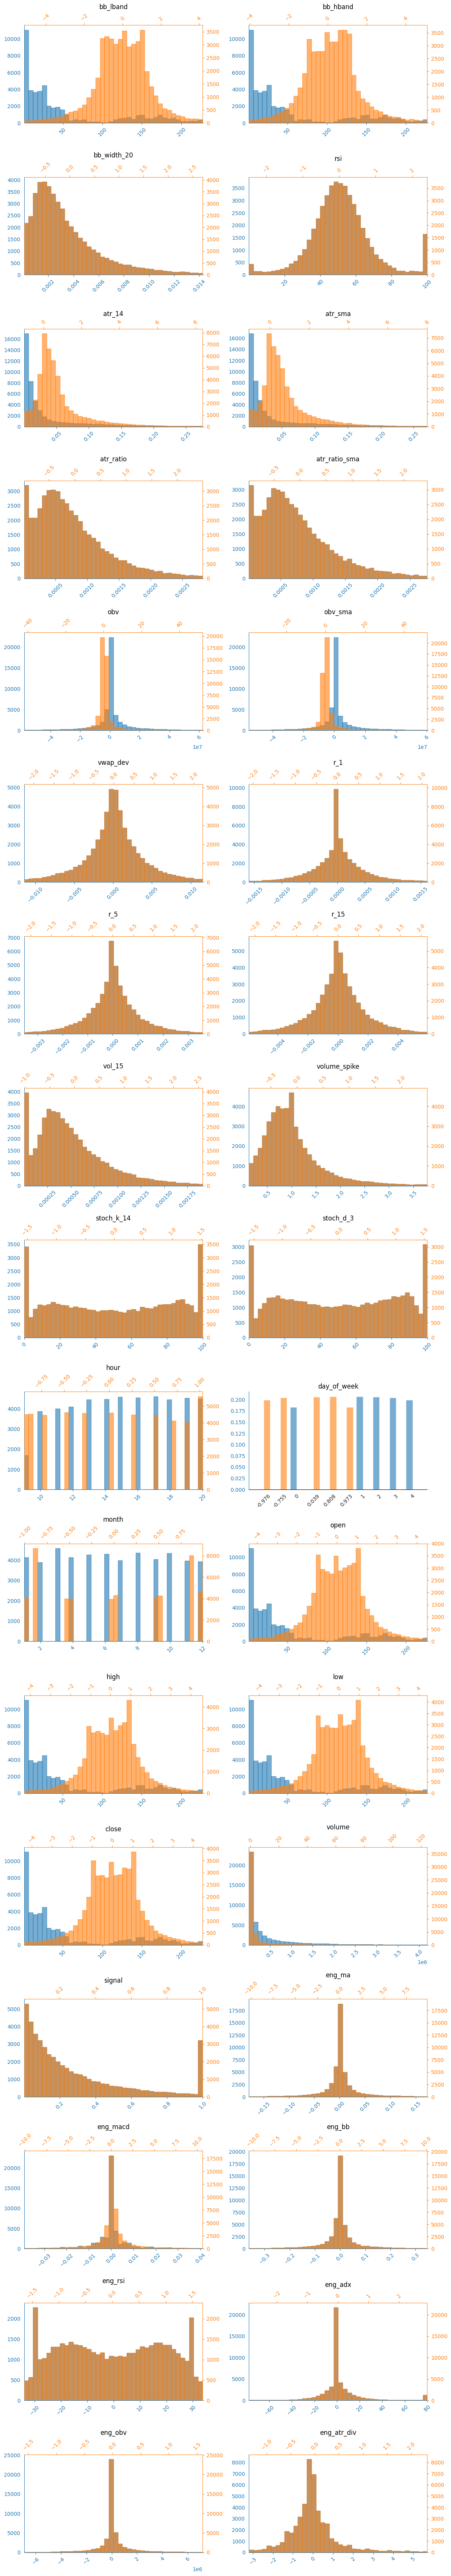

In [8]:
df_feat_scal = df_feat_all.drop(['bid','ask'], axis=1)

plots.plot_dual_histograms(
    df_before = df_feat_unsc,
    df_after  = df_feat_scal,
)